In [21]:
from drn_interactions.transforms.spikes import SpikesHandlerMulti
from drn_interactions.config import Config, ExperimentInfo
from drn_interactions.io import load_events, load_derived_generic
from drn_interactions.responders.foot_shock import SpikeRateResponders
from drn_interactions.io import load_derived_generic
from drn_interactions.transforms.spikes import SpikesHandler
from drn_interactions.transforms.shock_transforms import ShockUtils
from drn_interactions.plots import PAL_GREY_BLACK
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler
)
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%load_ext autoreload
%autoreload 2


sns.set_theme(style="ticks", context="paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


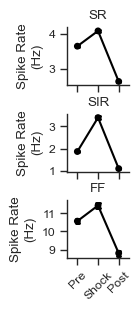

In [22]:
# SLOW TS CATPLOT

sessions = list(ExperimentInfo.foot_shock_sessions_10min)
neuron_types = (
    load_derived_generic("neuron_types.csv")
    .assign(neuron_type=lambda x: pd.Categorical(x.neuron_type, categories=["SR", "SIR", "FF"], ordered=True))
)
spikes_handler = SpikesHandlerMulti(
    block=["base_shock", "post_base_shock"], 
    bin_width=1, 
    session_names=sessions,
    t_start=-600, 
    t_stop=1200,
)
df = (
    spikes_handler.binned
    .merge(neuron_types)
    .assign(
        block=lambda x: np.select(
            [x["bin"] < 0, x["bin"] < 600, x["bin"] < 1200],
            ["Pre", "Shock", "Post"],
            )
        )
    .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(zscore))
)

g = sns.catplot(
    x="block", 
    y="counts", 
    row="neuron_type", 
    sharey=False,
    sharex=True,
    capsize=0.15, 
    height=1, 
    aspect=0.8, 
    color="black",
    kind="point", 
    data=df,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5))
    
)
g.set_xlabels("")
g.set_ylabels("Spike Rate\n(Hz)")
g.set_titles("{row_name}")
g.despine()
g.set_xticklabels(["Pre", "Shock", "Post"], rotation=45)
g.savefig(Config.fig_dir / "fs_fast_catplot.png", dpi=300)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


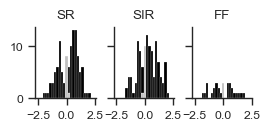

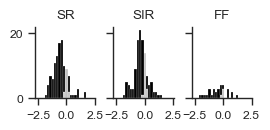

In [23]:
def slow_ts_hist_grid(df, height=0.933, aspect=0.75):
    g = sns.FacetGrid(
        data=df,
        col="neuron_type",
        sharey=True, 
        sharex=True, 
        height=height, 
        aspect=aspect,
        col_order=["SR", "SIR", "FF"],
        gridspec_kws={"wspace": 0.3},
    )
    g.map_dataframe(
        sns.histplot, 
        x="diff_inv", 
        hue="sig", 
        palette=PAL_GREY_BLACK,
        multiple="stack",
        alpha=1,
        hue_order=[True, False],
        bins=np.arange(-2.5, 2.5, 0.2),
        )
    g.set_xlabels("")
    g.set_ylabels("")
    return g 

# Slow TS Hists
slow_shock = load_derived_generic("slow_ts_foot_shock_unit_responders_pre_to_shock.csv")
slow_post = load_derived_generic("slow_ts_foot_shock_unit_responders_pre_to_post.csv")

df = (
    pd.concat((
    slow_shock.assign(Contrast="Pre to Shock"),
    slow_post.assign(Contrast="Pre to Post")
    ))
    .assign(diff_inv=lambda x: x["diff"] * -1)
)

g_shock = slow_ts_hist_grid(df.query("Contrast == 'Pre to Shock'"), aspect=1)
g_post = slow_ts_hist_grid(df.query("Contrast == 'Pre to Post'"), aspect=1)

g_shock.set_titles("{col_name}")
g_post.set_titles("{col_name}")

g_shock.savefig(Config.fig_dir / "fs_fast_hists_pre_to_shock.png", dpi=300)
g_post.savefig(Config.fig_dir / "fs_fast_hists_pre_to_post.png", dpi=300)


In [4]:
sessions = list(ExperimentInfo.foot_shock_sessions_10min)
events = load_events("base_shock")
spikes_handler = SpikesHandler(
    block="base_shock",
    t_start=0,
    t_stop=600,
    session_names=sessions,
    bin_width=1,
)
transformer = ShockUtils()
df_spikes = transformer.align_spikes(spikes_handler.spikes, events)
df_binned = transformer.aligned_binned_from_spikes(
    spikes_handler.spikes, 
    events,
    bin_width=0.05
    )
df_psth = transformer.average_trace_from_aligned_binned(df_binned)


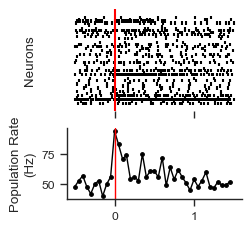

In [5]:
f = plt.figure(figsize=(2.4, 2.2),  constrained_layout=True)

axes = f.subplots(2, 1, sharex=True, gridspec_kw=dict(hspace=0.15, height_ratios=[1, 0.7]))
ax_dict = {name: ax for name, ax in zip(["spikes", "pop"], axes)}

session = "hamilton_35"
events = (
    df_spikes
    .query("session_name == @session")
    .event
    .unique()
)
event_idx = 2
event = events[event_idx]

# get trains from event
trains = [
    g.values for _, g in (
        df_spikes
        .query("session_name == @session and event == @event")
        .groupby("neuron_id")
        ["aligned"]
    )
]

# get population train for event
population_train = (
    df_binned
    .query("event == @event_idx")
    .drop("event", axis=1)
    .set_index(["bin"])
    .sum(axis=1)
)

# plot raster
_ = ax_dict["spikes"].eventplot(
    trains, 
    color="black", 
    linewidths=1.5, 
    linelengths=1.6
    )
ax_dict["spikes"].axvline(0, color="red", linewidth=1.5)
ax_dict["spikes"].set_ylabel("Neurons")
ax_dict["spikes"].set_yticks([])
sns.despine(ax=ax_dict["spikes"], left=True, bottom=True)

# plot pop
ax_dict["pop"].plot(population_train.index, population_train.values, color="black", linewidth=1)
ax_dict["pop"].scatter(population_train.index, population_train.values, color="black", s=7)

ax_dict["pop"].axvline(0, color="red", linewidth=1)
ax_dict["pop"].set_ylabel("Population Rate\n(Hz)")
f.align_ylabels()

sns.despine(ax=ax_dict["pop"])

f.savefig(Config.fig_dir / "fs_example_raster_single_trail.png", dpi=300)

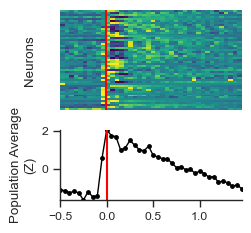

In [6]:
session_units = neuron_types.loc[lambda x: x.session_name == session].neuron_id.unique()

f = plt.figure(figsize=(2.4, 2.2), constrained_layout=True)

axes = f.subplots(2, 1, sharex=False, gridspec_kw=dict(hspace=0.15, height_ratios=[1, 0.7], ))
ax_dict = {name: ax for name, ax in zip(["heat", "pop"], axes)}

session_zscore =     (
    df_psth
    .transpose()
    .loc[session_units]
)
# session_zscore.columns = np.roll(session_zscore.columns, -1)

sns.heatmap(data=session_zscore.apply(zscore, axis=1), 
        cmap="viridis", 
        cbar=False, 
        xticklabels=[], 
        center=0, 
        vmin=-3, 
        vmax=3, 
        ax=ax_dict["heat"],
        yticklabels=[],
        )
ax_dict["heat"].set_ylabel("Neurons")
ax_dict["heat"].axvline(10, color="red", linewidth=1.5)
ax_dict["heat"].set_xlabel("")

pop = session_zscore.sum().transform(zscore)
ax_dict["pop"].scatter(pop.index, pop.values, color="black", s=7)
ax_dict["pop"].plot(pop.index, pop.values, color="black", linewidth=1)



ax_dict["pop"].axvline(0, color="red", linewidth=1.5)
sns.despine(ax=ax_dict["pop"])
ax_dict["pop"].margins(0)
ax_dict["pop"].set_ylabel("Population Average\n(Z)")
f.align_ylabels()
f.savefig(Config.fig_dir / "fs_example_raster_trail_average.png", dpi=300)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


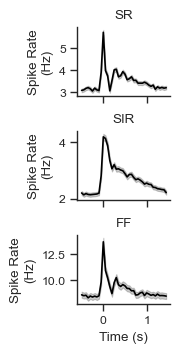

In [7]:

def facet_line(df):
    g = sns.FacetGrid(df, row="neuron_type",  sharey=False,  sharex=True, height=1.2, aspect=1, gridspec_kws=dict(hspace=0.5 ))
    g.map_dataframe(sns.lineplot, x="bin", y="rate", color="black",)
    return g

g = (
    df_binned
    .melt(id_vars=["event", "bin"], var_name="neuron_id", value_name="counts")
    .merge(neuron_types)
    .assign(rate=lambda x: x.counts / 0.05)
    .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(zscore))
    .pipe(facet_line)
)
g.set_titles("{row_name}")
g.set_ylabels("Spike Rate\n(Hz)")
g.set_xlabels("Time (s)")
g.savefig(Config.fig_dir / "fs_fast_avg_psth_by_type.png", dpi=300)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


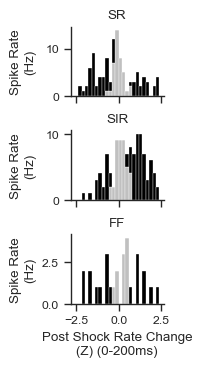

In [8]:
# hists
df_effects = load_derived_generic("fast_fs_foot_shock_unit_responders.csv").merge(neuron_types)

g = sns.FacetGrid(
    df_effects, 
    row="neuron_type",  
    sharey=False,  
    sharex=True, 
    height=1.2, 
    aspect=1, 
    gridspec_kws=dict(hspace=0.5),
    row_order=["SR", "SIR", "FF"]
    )

g.map_dataframe(
    sns.histplot, 
    x="Diff", 
    color="black", 
    hue="sig",
    palette=PAL_GREY_BLACK,
    multiple="stack",
    alpha=1,
    hue_order=[True, False],
    bins=np.arange(-2.6, 2.6, 0.2),
    
    )

g.set_titles("{row_name}")
g.set_ylabels("Neuron Count")
g.set_xlabels("Post Shock Rate Change\n(Z) (0-200ms)")
g.figure.align_ylabels()
g.savefig(Config.fig_dir / "fs_fast_hists.png", dpi=300)

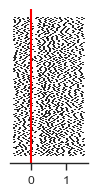

In [9]:
f, ax = plt.subplots(figsize=(1, 2))

sr_units = neuron_types.query("neuron_type == 'SR' and session_name == 'hamilton_35'").neuron_id.unique()

trains = [g["aligned"].values for _ , g in df_spikes.query("neuron_id == @sr_units[1]").groupby("event")]

_ = ax.eventplot(trains, color="black")
ax.axvline(0, color="red", linewidth=1.5)
sns.despine(ax=ax, left=True)
ax.set_yticks([])

f.savefig(Config.fig_dir / "fs_raster_same_unit.png", dpi=300)

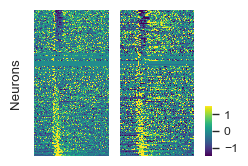

In [10]:
f  = plt.figure(figsize=(2.3, 1.9))
ax = f.subplot_mosaic(
    """AB.
    ABC
    """,
    gridspec_kw=dict(
        height_ratios=[1, 0.6], 
        width_ratios=[1, 1, 0.1],),
    )

(
    load_derived_generic("psth_first_half.csv")
    .set_index("neuron_id")
    .apply(zscore, axis=1)
    .pipe(
        sns.heatmap, 
        cmap="viridis",
        cbar=False,
        vmin=-2,
        vmax=2,
        ax=ax["A"],
        yticklabels=[],
        xticklabels=[],
        )
)
(
    load_derived_generic("psth_second_half.csv")
    .set_index("neuron_id")
    .apply(zscore, axis=1)
    .pipe(
        sns.heatmap, 
        cmap="viridis",
        cbar_ax=ax["C"],
        vmin=-1.5,
        vmax=1.5,
        ax=ax["B"],
        yticklabels=[],
        xticklabels=[],
        )
)
ax["A"].set_ylabel("Neurons")
ax["B"].set_ylabel("")

f.savefig(Config.fig_dir / "Halfs PSTH Heats.png", dpi=300)

C:\Users\roryl\AppData\Local\Temp\ipykernel_6724\780776069.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  f.tight_layout()
C:\Users\roryl\AppData\Local\Temp\ipykernel_6724\780776069.py:20: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  f.savefig(Config.fig_dir / "fs_mi_bars.png", dpi=300, bbox_inches="tight")
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


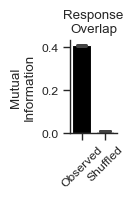

In [11]:
f, ax = plt.subplots(
    figsize=(0.6, 1.2), 
    constrained_layout=True)

df_mi = load_derived_generic("mi_psth_halfs.csv")
sns.barplot(
    data=df_mi, 
    x="Method", 
    y="MI", 
    palette=PAL_GREY_BLACK,
    capsize=0.4,
    ax=ax,
    )
sns.despine(ax=ax)
ax.set_title("Response\nOverlap")
ax.set_ylabel("Mutual\nInformation")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
f.tight_layout()
f.savefig(Config.fig_dir / "fs_mi_bars.png", dpi=300, bbox_inches="tight")


In [24]:
df_clust = pd.merge(
    left=(
    load_derived_generic(
        "fast_fs_foot_shock_unit_responders.csv"
        )
    .rename(columns={"Diff": "Fast Time Scale"})
    [["neuron_id", "Fast Time Scale", "neuron_type"]]
    ),
    right=(
        load_derived_generic(
        "slow_ts_foot_shock_unit_responders_pre_to_shock.csv"
        )
    .rename(columns={"diff_inv": "Slow Time Scale"})
    [["neuron_id", "Slow Time Scale", "neuron_type"]]
    ),
)


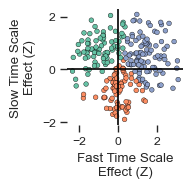

In [25]:


f, ax = plt.subplots(figsize=(1.5, 1.5))

X = df_clust[["Fast Time Scale", "Slow Time Scale"]]

p = make_pipeline(
    # RobustScaler(), 
    KMeans(n_clusters=3, random_state=0),
    )
df_clust["cluster"] = pd.Categorical(p.fit_predict(X))
sns.set_palette("Set2")
sns.scatterplot(
    data=df_clust,
    x="Fast Time Scale",
    y="Slow Time Scale",
    hue="cluster",
    ax=ax,
    size=1,
    edgecolor="black",
)

ax.axhline(0, color="black")
ax.axvline(0, color="black")

ax.set_ylabel("Slow Time Scale\nEffect (Z)")
ax.set_xlabel("Fast Time Scale\nEffect (Z)")
sns.despine(ax=ax, left=True, bottom=True)
ax.legend().remove()

df_clust.to_csv(Config.derived_data_dir / "fs_resonse_clusters.csv", index=False)
# f.savefig(
#     Config.fig_dir / "neurontypes_footshock_scatter.png", 
#     dpi=300,
#     bbox_inches="tight",
#     )


Text(0, 0.5, 'Neuron Count')

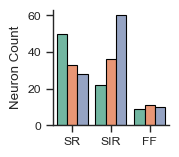

In [20]:
f, ax = plt.subplots(figsize=(1.5, 1.5))


sns.countplot(
    x="neuron_type", 
    hue="cluster", 
    data=df_clust,
    ax=ax,
    edgecolor="black",
    order=["SR", "SIR", "FF"]
    )
sns.despine(ax=ax,)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Neuron Count")
# f.savefig(
#     Config.fig_dir / "neurontypes_counts_psth.png", 
#     dpi=300,
#     bbox_inches="tight",
#     )